# <span style="color:#ff1414"> BEDtools analysis. </span>

This is a script to answer research questions outlined elsewhere. In summary, this script:

1. compares methylation results between different methylation-callers, and between different methylation sequencing methods.

2. compares methylation between genes and non-gene regions

3. compares methylation between transposons and non-repetitive regions

4. compares transposons and genes


Note:
- PB/pb = PacBio
- ONT/ont = Oxford Nanopore Technology
- NP = Nanopolish

In [429]:
import pybedtools
from pybedtools import BedTool
import os
import glob
import pprint
#import numpy # need for p-value stats
import scipy
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from matplotlib_venn import venn2

In [430]:
#First we need to define the base dirs
DIRS ={}
DIRS['BASE1'] = '/home/anjuni/methylation_calling/pacbio'
DIRS['BASE2'] = '/home/anjuni/analysis'
DIRS['BED_INPUT'] = os.path.join(DIRS['BASE2'], 'bedtools_output', 'sequencing_comparison')
DIRS['GFF_INPUT'] = os.path.join(DIRS['BASE2'], 'gff_output')
DIRS['WINDOW_OUTPUT'] = os.path.join(DIRS['BASE2'], 'windows')
DIRS['WINDOW_INPUT'] = os.path.join(DIRS['BASE2'], 'input_for_windows')
DIRS['REF'] = '/home/anjuni/Pst_104_v13_assembly/'
DIRS['TEST_COV'] = os.path.join(DIRS['BASE2'], 'coverage/test_feature_files')

In [438]:
pprint.pprint(DIRS) # add the additional ones below to the cell above maybe?

{'5MC_CUTOFFS': '/home/anjuni/methylation_calling/pacbio/input/sorted_bed_files/cutoffs_5mC',
 '6MA_CUTOFFS': '/home/anjuni/methylation_calling/pacbio/input/sorted_bed_files/cutoffs_6mA',
 'BASE1': '/home/anjuni/methylation_calling/pacbio',
 'BASE2': '/home/anjuni/analysis',
 'BED_CUTOFFS': '/home/anjuni/methylation_calling/pacbio/input/sorted_bed_files/cutoffs',
 'BED_INPUT': '/home/anjuni/analysis/bedtools_output/sequencing_comparison',
 'FEATURES': '/home/anjuni/analysis/coverage/feature_files',
 'GFF_INPUT': '/home/anjuni/analysis/gff_output',
 'I_FROM_C': '/home/anjuni/analysis/bedtools_output/intersects_from_cutoffs',
 'METHYL': '/home/anjuni/analysis/input_for_windows/methylation_files',
 'REF': '/home/anjuni/Pst_104_v13_assembly/',
 'TEST_COV': '/home/anjuni/analysis/coverage/test_feature_files',
 'WINDOW_INPUT': '/home/anjuni/analysis/input_for_windows',
 'WINDOW_OUTPUT': '/home/anjuni/analysis/windows'}


In [33]:
#Quick chech if directories exist
for value in DIRS.values():
    if not os.path.exists(value):
        print('%s does not exist' % value)

In [34]:
#Make filepaths
bed_file_list = [fn for fn in glob.iglob('%s/*.bed' % DIRS['BED_INPUT'], recursive=True)]
gff_file_list = [fn for fn in glob.iglob('%s/*anno.gff3' % DIRS['GFF_INPUT'], recursive=True)]
te_file_list = [fn for fn in glob.iglob('%s/*.gff' % DIRS['GFF_INPUT'], recursive=True)]

In [35]:
#Check that the list works
print(*bed_file_list, sep='\n')
print(*gff_file_list, sep='\n')
print(*te_file_list, sep='\n')

/home/anjuni/analysis/bedtools_output/sequencing_comparison/5mC_CpG_tombo_np.bed
/home/anjuni/analysis/bedtools_output/sequencing_comparison/5mC_tombo_np.bed
/home/anjuni/analysis/bedtools_output/sequencing_comparison/6mA_pb_ont.bed
/home/anjuni/analysis/bedtools_output/sequencing_comparison/5mC_hc_tombo_sorted.bed
/home/anjuni/analysis/bedtools_output/sequencing_comparison/5mC_CpG_np_tombo.bed
/home/anjuni/analysis/bedtools_output/sequencing_comparison/6mA_ont_pb.bed
/home/anjuni/analysis/bedtools_output/sequencing_comparison/5mC_np_tombo.bed
/home/anjuni/analysis/gff_output/Pst_104E_v13_p_ctg_combined_sorted_anno.gff3
/home/anjuni/analysis/gff_output/Pst_104E_v13_h_ctg_combined_sorted_anno.gff3
/home/anjuni/analysis/gff_output/Pst_104E_v13_h_ctg.REPET.sorted.filtered.superfamily.gff
/home/anjuni/analysis/gff_output/Pst_104E_v13_p_ctg.REPET.sorted.filtered.superfamily.gff
/home/anjuni/analysis/gff_output/Pst_104E_v13_ph_ctg.REPET.sorted.filtered.superfamily.gff


## <span style='color:deeppink'> 1. Comparing methylation sequencing methods <span/>

In [8]:
%%bash

# find overlap between 6mA from PacBio and Nanopore for 6mA data

pb=/home/anjuni/methylation_calling/pacbio/input/sorted_bed_files/6mA_prob_smrtlink_sorted.bed # use basecall accuracy instead of Phred score
ont=/home/anjuni/methylation_calling/pacbio/input/sorted_bed_files/6mA_hc_tombo_sorted.bed # use sites with non-zero methylation

out1=/home/anjuni/analysis/bedtools_output/sequencing_comparison/6mA_pb_ont.bed
out2=/home/anjuni/analysis/bedtools_output/sequencing_comparison/6mA_ont_pb.bed

echo $pb
echo $ont

bedtools intersect -a $pb -b $ont > $out1
bedtools intersect -a $ont -b $pb > $out2

/home/anjuni/methylation_calling/pacbio/input/sorted_bed_files/6mA_prob_smrtlink_sorted.bed
/home/anjuni/methylation_calling/pacbio/input/sorted_bed_files/6mA_hc_tombo_sorted.bed


In [12]:
%%bash

#check how many overlapping sites there were

cd /home/anjuni/analysis/bedtools_output/sequencing_comparison/
echo PacBio sites:
less /home/anjuni/methylation_calling/pacbio/input/sorted_bed_files/6mA_prob_smrtlink_sorted.bed | wc -l

echo Overlapping sites:
less 6mA_pb_ont.bed | wc -l

echo Nanopore sites:
less /home/anjuni/methylation_calling/pacbio/input/sorted_bed_files/6mA_hc_tombo_sorted.bed | wc -l

echo Overlapping sites:
less 6mA_ont_pb.bed | wc -l

echo Total adenine sites:
less /home/anjuni/methylation_calling/pacbio/input/sorted_bed_files/6mA_tombo_sorted.bed | wc -l

PacBio sites:
88932
Overlapping sites:
84733
Nanopore sites:
83451878
Overlapping sites:
84733
Total adenine sites:
85779879


In [362]:
# Descriptive Statistics

print('Percentage overlap between PacBio and Nanopore as a proportion of PB sites:', "{0:.3f}%".format(100*84733/88932))
# overlap between pb and ont, divided by total PacBio sites

print('Percentage overlap between PacBio and Nanopore as a proportation of ONT sites:', "{0:.3f}%".format(100*84733/83451878))
# = overlap between pb and ont, divided by total Nanopore sites

print('Percentage adenine methylation from overlap:', "{0:.3f}%".format(100*84733/85779879))
# = overlapping sites, divided by total number of adenines (gained from number of lines on tombo file. tombo counts all adenines)

Percentage overlap between PacBio and Nanopore as a proportion of PB sites: 95.278%
Percentage overlap between PacBio and Nanopore as a proportation of ONT sites: 0.102%
Percentage adenine methylation from overlap: 0.099%


#### <span style='color:deeppink'> Observations <span/>

Very high similarity between Nanopore and PacBio, when compared to PacBio. But PacBio sites are only a small fraction of Tombo sites, and only include highly accurate sites.

When overlapping PacBio and all Nanopore (Tombo) sites, there was a higher overlap (88932) than when overlapping only non-zero PB and ONT sites (84733). This indicates PB detected sites that Nanopore did not, and these were high probability sites that were missed, as PB only had high probability (>99% basecall accuracy) sites.

There are also more overlapped sites when using the zero-probability sites from tombo, compared to only using only high confidence sites from both. This also suggests that Tombo/Nanopore had missed some methylated sites.

## <span style='color:#ff14ff'> 2. Comparing methylation detection methods <span/>

In [3]:
%%bash

# compare overlap between Tombo and Nanopolish for 5mC data
np=/home/anjuni/methylation_calling/pacbio/input/sorted_bed_files/5mC_hc_nanopolish_sorted.bed
tombo=/home/anjuni/methylation_calling/pacbio/input/sorted_bed_files/5mC_hc_tombo_sorted.bed

out1=/home/anjuni/analysis/bedtools_output/sequencing_comparison/5mC_np_tombo.bed
out2=/home/anjuni/analysis/bedtools_output/sequencing_comparison/5mC_tombo_np.bed

echo $np
echo $tombo

bedtools intersect -a $np -b $tombo > $out1
bedtools intersect -a $tombo -b $np > $out2

/home/anjuni/methylation_calling/pacbio/input/sorted_bed_files/5mC_hc_nanopolish_sorted.bed
/home/anjuni/methylation_calling/pacbio/input/sorted_bed_files/5mC_hc_tombo_sorted.bed


In [370]:
%%bash

#check how many overlapping sites there were

cd /home/anjuni/analysis/bedtools_output/sequencing_comparison/

echo Nanopolish sites:
less /home/anjuni/methylation_calling/pacbio/input/sorted_bed_files/5mC_hc_nanopolish_sorted.bed | wc -l

echo Tombo sites:
less /home/anjuni/methylation_calling/pacbio/input/sorted_bed_files/5mC_hc_tombo_sorted.bed | wc -l

echo Overlapping sites:
less 5mC_np_tombo.bed | wc -l

echo Total cytosine sites:
less /home/anjuni/methylation_calling/pacbio/input/sorted_bed_files/5mC_tombo_sorted.bed | wc -l

echo Total CpG sites:
less /home/anjuni/methylation_calling/pacbio/input/sorted_bed_files/5mC_nanopolish_sorted.bed | wc -l

Nanopolish sites:
3783438
Tombo sites:
67308386
Overlapping sites:
1681653
Total cytosine sites:
68536018
Total CpG sites:
5302131


In [363]:
# Descriptive Statistics

print('Percentage overlap between Nanopolish and Tombo as a proportion of NP sites:', "{0:.3f}%".format(100*1681653/3783438))
# overlap between np and tombo, divided by total NP sites

print('Percentage overlap between Nanopolish and Tombo as a proportation of Tombo sites:', "{0:.3f}%".format(100*1681653/67308386))
# = overlap between np and tombo, divided by total Tombo sites

print('Percentage cytosine methylation from overlap:', "{0:.3f}%".format(100*1681653/68536018))
# = overlapping sites, divided by total number of cytosines (gained from number of lines on tombo file. tombo counts all cytosines)

print('Percentage of CpG sites methylated from overlap:', "{0:.3f}%".format(100*1681653/5302131))
# = overlapping sites, divided by total number of CpG sites (gained from number of lines on np file. np counts all cpg sites)

Percentage overlap between Nanopolish and Tombo as a proportion of NP sites: 44.448%
Percentage overlap between Nanopolish and Tombo as a proportation of Tombo sites: 2.498%
Percentage cytosine methylation from overlap: 2.454%
Percentage of CpG sites methylated from overlap: 31.717%


#### <span style='color:#ff14ff'> Observations <span/>
While adenine methylation had high similarity between ONT and PB, cytosine methylation had only 44% similarity between NP and tombo. This is likely because NP only has CpG sites, and Tombo has all cytosine sites, so Tombo will detect far more potentially methylated sites, even those that are not CpG sites, so it will have far more sites than NP to begin with.

### <span style='color:#ff14ff'> 2.A Taking CpG sites into account when comparing methylation detection methods <span/>

In [24]:
%%bash

#check how many cytosine sites and CpG sites there are

cd /home/anjuni/methylation_calling/pacbio/input/sorted_bed_files/

echo CpG sites:
less 5mC_nanopolish_sorted.bed | wc -l

echo Cytosine sites:
less 5mC_tombo_sorted.bed | wc -l

CpG sites:
5302131
Cytosine sites:
68536018


In [364]:
# Descriptive Statistics

print('Percentage of CpG sites as a proportion of cytosine sites:', "{0:.3f}%".format(100*5302131/68536018))
# np sites divided by tombo sites

Percentage of CpG sites as a proportion of cytosine sites: 7.736%


#### <span style='color:#ff14ff'> Solution <span/>
1. Make a file of methylated CpG sites detected by Tombo.
2. Intersect this with methylated (CpG) sites detected by Nanopolish.

I will be overlapping CpG sites from Tombo and NP, because NP only has CpG sites and Tombo has all cytosine sites.
So from the start, the overlap wouldn't have been accurate, because tombo considers sites that NP does not.

#### <span style='color:#ff14ff'> CpG Sites <span/>

In [160]:
%%bash

# make a file of CpG sites from tombo
all_cpg=/home/anjuni/methylation_calling/pacbio/input/sorted_bed_files/5mC_nanopolish_sorted.bed
all_tombo=/home/anjuni/methylation_calling/pacbio/input/sorted_bed_files/5mC_hc_tombo_sorted.bed
tombo_cpg=/home/anjuni/methylation_calling/pacbio/input/sorted_bed_files/5mC_hc_tombo_sorted.CpG.bed

bedtools intersect -a $all_tombo -b $all_cpg > $tombo_cpg

In [161]:
%%bash

# intersect Tombo and NP CpG sites
tombo_cpg=/home/anjuni/methylation_calling/pacbio/input/sorted_bed_files/5mC_hc_tombo_sorted.CpG.bed
np_cpg=/home/anjuni/methylation_calling/pacbio/input/sorted_bed_files/5mC_hc_nanopolish_sorted.bed
m_tombo_cpg=/home/anjuni/analysis/bedtools_output/sequencing_comparison/5mC_CpG_tombo_np.bed
m_np_cpg=/home/anjuni/analysis/bedtools_output/sequencing_comparison/5mC_CpG_np_tombo.bed

bedtools intersect -a $tombo_cpg -b $np_cpg > $m_tombo_cpg
bedtools intersect -a $np_cpg -b $tombo_cpg > $m_np_cpg

In [369]:
%%bash

#check how many overlapping sites there were
cd /home/anjuni/analysis/bedtools_output/sequencing_comparison/

echo Nanopolish methylated CpG sites:
less /home/anjuni/methylation_calling/pacbio/input/sorted_bed_files/5mC_hc_nanopolish_sorted.bed | wc -l

echo Tombo methylated CpG sites:
less /home/anjuni/methylation_calling/pacbio/input/sorted_bed_files/5mC_hc_tombo_sorted.CpG.bed | wc -l

echo Overlapping methylated CpG sites:
less 5mC_CpG_tombo_np.bed | wc -l

echo Total CpG sites:
less /home/anjuni/methylation_calling/pacbio/input/sorted_bed_files/5mC_nanopolish_sorted.bed | wc -l

Nanopolish methylated CpG sites:
3783438
Tombo methylated CpG sites:
5167951
Overlapping methylated CpG sites:
3708640
Total CpG sites:
5302131


In [371]:
# Descriptive Statistics

print('Percentage overlap between Nanopolish and Tombo as a proportion of NP CpG sites:', "{0:.3f}%".format(100*1681653/3783438))
# overlap between np and tombo, divided by total NP CpG sites

print('Percentage overlap between Nanopolish and Tombo as a proportation of Tombo CpG sites:', "{0:.3f}%".format(100*1681653/5167951))
# = overlap between np and tombo, divided by total Tombo CpG sites

print('Percentage of CpG sites methylated:', "{0:.3f}%".format(100*1681653/5302131))
# = overlapping sites, divided by total number of CpG sites (gained from number of lines on np file. np counts all cpg sites)

Percentage overlap between Nanopolish and Tombo as a proportion of NP CpG sites: 44.448%
Percentage overlap between Nanopolish and Tombo as a proportation of Tombo CpG sites: 32.540%
Percentage of CpG sites methylated: 31.717%


#### <span style='color:#ff14ff'> Observations <span/>
While the overlap between Tombo and NP didn't change after only comparing CpG sites, the nearly 50% overlap may be because NP only considers one strand while Tomb considers both.

This may be resolved by using only the plus file from Tombo and comparing its results to NP.

### <span style='color:#ff14ff'> 2.B Test out whether Nanopolish only detects (+) strand <span/>
Intersect tombo 5mC (-) strand file with nanopolish file to see if there is overlap. Then intersect the tombo (+) strand with nanopolish.

The 44% match may just be because I, for some reason, put all the nanopolish sites as (+) strand when making the original BED file :P

In [147]:
%%bash

#Sort the initial tombo bed files, because they were not sorted and slowed down the intersection

tombo_minus=/home/anjuni/methylation_calling/pacbio/input/bed_files/initial_bed_files/5mC_minus_tombo.bed
tombo_plus=/home/anjuni/methylation_calling/pacbio/input/bed_files/initial_bed_files/5mC_plus_tombo.bed
nanopolish=/home/anjuni/methylation_calling/pacbio/input/bed_files/5mC_s_nanopolish.bed

sort_tombo_minus=/home/anjuni/methylation_calling/pacbio/input/bed_files/5mC_minus_tombo_sorted.bed
sort_tombo_plus=/home/anjuni/methylation_calling/pacbio/input/bed_files/5mC_plus_tombo_sorted.bed

sortBed -i $tombo_minus > $sort_tombo_minus
sortBed -i $tombo_plus > $sort_tombo_plus

In [148]:
%%bash

#Intersect the (+) and (-) BED files with nanopolish file
#to see whether Nanopolish has methylation-calls on both strands :)

sort_tombo_minus=/home/anjuni/methylation_calling/pacbio/input/bed_files/5mC_minus_tombo_sorted.bed
sort_tombo_plus=/home/anjuni/methylation_calling/pacbio/input/bed_files/5mC_plus_tombo_sorted.bed
nanopolish=/home/anjuni/methylation_calling/pacbio/input/bed_files/5mC_s_nanopolish.bed

intersectBed -a $nanopolish -b $sort_tombo_minus > /home/anjuni/methylation_calling/pacbio/input/bed_files/nano_minus_tombo_overlap.bed
intersectBed -a $nanopolish -b $sort_tombo_plus > /home/anjuni/methylation_calling/pacbio/input/bed_files/nano_plus_tombo_overlap.bed

In [150]:
%%bash

#Compare the number of NP sites to Tombo sites on the forward and reverse strand
cd /home/anjuni/methylation_calling/pacbio/input/bed_files
echo "The number of CpG sites captured by Nanopolish:"
less 5mC_s_nanopolish.bed | wc -l
echo "The number of overlapping sites captured by Nanopolish and by Tombo on the forward strand of the reference genome:"
less nano_plus_tombo_overlap.bed  | wc -l
echo "The number of overlapping sites captured by Nanopolish and by Tombo on the reverse strand of the reference genome:"
less nano_minus_tombo_overlap.bed  | wc -l

The number of sites captured by Nanopolish:
5302131
The number of overlapping sites captured by Nanopolish and by Tombo on the forward strand of the reference genome:
5221309
The number of overlapping sites captured by Nanopolish and by Tombo on the reverse strand of the reference genome:
0


In [372]:
print('Percentage overlap between Nanopolish and Tombo (forward strand) as a proportion of NP sites:', "{0:.3f}%".format(100*5221309/5302131))
# overlap between np and tombo, divided by total NP sites

Percentage overlap between Nanopolish and Tombo (forward strand) as a proportion of NP sites: 98.476%


There is a 98% similarity between Nanopolish sites and Tombo forward strand sites, but no similarity between Nanopolish sites and Tombo reverse strand sites, indicating that the 44% similarity between Nanopolish and Tombo from earlier was because Nanopolish only detected methylation on the forward strand.

I am currently re-running Nanopolish methylation-calling in case there was a mistake in the code earlier, causing it to ignore the reverse strand. Re-running the test run for pcontig_109 showed no difference in output to the previous one. They had the same number of sites (46801) and had the same output for the first 10 lines and last 10 lines. Now I think there wasn't a mistake because I only copied the index files to a new folder to save them back to the output folder, while a copy of all index files remained in the original fastq folder. This allowed methylation-calling to continue.

Based on these results, I will intersect the methylated forward strand CpG sites that Tombo detected with the the Nanopolish site, to ensure only related sites intersect :)

In [156]:
%%bash

#bedtools script to check nanopolish results
#if the subtract file is empty, the initial nanopolish run was accurate

nano1=/home/anjuni/methylation_calling/pacbio/input/bed_files/5mC_s_nanopolish.bed
nano2=/home/anjuni/methylation_calling/pacbio/input/bed_files/5mC_rerun_s_nanopolish.bed
nano1_2_sub=/home/anjuni/methylation_calling/pacbio/input/bed_files/nanopolish_rerun_subtract.bed

bedtools subtract -a $nano1 -b $nano2 > $nano1_2_sub

In [158]:
!echo "Number of site differences between the original Nanopolish run and the re-run"
!less /home/anjuni/methylation_calling/pacbio/input/bed_files/nanopolish_rerun_subtract.bed | wc -l

Number of site differences between the original Nanopolish run and the re-run
0


As there was no difference in sites between each Nanopolish run, the original run had no issues causing only the (+) strand to be detected and this issue is a result of the software.

### <span style='color:#ff14ff'> 2.C Finding overlap between forward strand CpG Sites <span/>

In [164]:
%%bash

#Make a tombo file with only forward strand CpG to match the Nanopolish data
grep '+' /home/anjuni/methylation_calling/pacbio/input/sorted_bed_files/5mC_hc_tombo_sorted.CpG.bed > /home/anjuni/methylation_calling/pacbio/input/sorted_bed_files/5mC_hc_tombo_sorted.CpG.plus.bed

#This file ended up being exactly the same as the original CpG file for Tombo, but this new file will be used for added detail

In [165]:
%%bash


# compare overlap between Tombo and Nanopolish for forward strand CpG 5mC data
np=/home/anjuni/methylation_calling/pacbio/input/sorted_bed_files/5mC_hc_nanopolish_sorted.bed
tombo=/home/anjuni/methylation_calling/pacbio/input/sorted_bed_files/5mC_hc_tombo_sorted.CpG.plus.bed

out1=/home/anjuni/analysis/bedtools_output/sequencing_comparison/5mC_plus_CpG_np_tombo.bed
out2=/home/anjuni/analysis/bedtools_output/sequencing_comparison/5mC_plus_CpG_tombo_np.bed

echo $np
echo $tombo

bedtools intersect -a $np -b $tombo > $out1
bedtools intersect -a $tombo -b $np > $out2

/home/anjuni/methylation_calling/pacbio/input/sorted_bed_files/5mC_hc_nanopolish_sorted.bed
/home/anjuni/methylation_calling/pacbio/input/sorted_bed_files/5mC_hc_tombo_sorted.CpG.plus.bed


In [374]:
%%bash

#Compare the number of (+) strand CpG NP sites to (+) strand CpG Tombo sites on the forward strand
cd /home/anjuni/methylation_calling/pacbio/input/sorted_bed_files
echo "The number of CpG sites captured by Nanopolish:"
less 5mC_hc_nanopolish_sorted.bed | wc -l
echo "The number of CpG sites captured by Tombo on the forward strand:"
less 5mC_hc_tombo_sorted.CpG.plus.bed | wc -l
echo "The number of overlapping sites captured by Nanopolish and by Tombo on the forward strand of the reference genome:"
less /home/anjuni/analysis/bedtools_output/sequencing_comparison/5mC_plus_CpG_tombo_np.bed  | wc -l

The number of CpG sites captured by Nanopolish:
3783438
The number of CpG sites captured by Tombo on the forward strand:
5167951
The number of overlapping sites captured by Nanopolish and by Tombo on the forward strand of the reference genome:
3708640


In [375]:
print('Percentage overlap between Nanopolish and Tombo (forward strand) as a proportion of NP sites:', "{0:.3f}%".format(100*3708640/3783438))
# overlap between np and tombo, divided by total NP sites
print('Percentage overlap between Nanopolish and Tombo (forward strand) as a proportion of Tombo sites:', "{0:.3f}%".format(100*3708640/5167951))
# overlap between np and tombo, divided by total Tombo sites

Percentage overlap between Nanopolish and Tombo (forward strand) as a proportion of NP sites: 98.023%
Percentage overlap between Nanopolish and Tombo (forward strand) as a proportion of Tombo sites: 71.762%


There was a 98% overlap between Nanopolish and Tombo sites, as a proportion of Nanopolish sites, as this was the smaller dataset. Using the positive strand CpG sites increased the overlap from 44% to 98%.

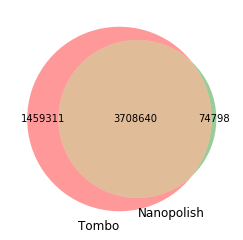

In [384]:
# First way to call the 2 group Venn diagram:
#The number of CpG sites captured by Nanopolish:
#3783438
#The number of CpG sites captured by Tombo on the forward strand:
#5167951
#The number of overlapping sites captured by Nanopolish and by Tombo on the forward strand of the reference genome:
#3708640
c = 3708640
a = 5167951-c
b = 3783438-c
venn2(subsets = (a, b, c), set_labels = ('Tombo', 'Nanopolish'))
plt.show()

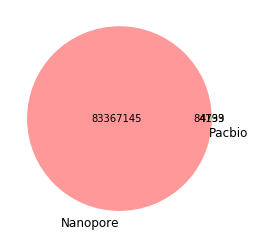

In [390]:
# First way to call the 2 group Venn diagram:
#PacBio sites:
#88932
#Overlapping sites:
#84733
#Nanopore sites:
#83451878

c = 84733
a = 83451878-c
b = 88932-c
venn2(subsets = (a, b, c), set_labels = ('Nanopore', 'Pacbio'))
plt.show()

In [ ]:
# Venn diagrams don't look good, so table of percentages will be used

For the rest of the analysis, I will use the overlapped files for 5mC and 6mA data, and the Tombo files. This is because the Tombo files consider all possible A and C sites in the genome, and provide some consistency between the 6mA and 5mC data. In contrast, Nanopolish only detects 5mC at CpG sites on the forward strand, and SMRTLink does not provide a methylation-call accuracy value that is comparable to the accuracy in Nanopolis and Tombo. While Nanopolish and Tombo use the fraction of reads for the site that are methylated, SMRTLink uses a Phred score to determine methylation-call accuracy.

## <span style='color:#8a14ff'> 3. Making cutoff files. <span/>

### <span style='color:#8a14ff'> 3.A Making cutoff files from five original methylation-calling files, and intersect the two sequencing methods and the two methyaltion-callers. <span/>

In [496]:
# Make the list of cutoffs
cutoff_list = [1.00, 0.99, 0.95, 0.90, 0.80, 0.70, 0.60, 0.50, 0.40, 0.30, 0.20, 0.10, 0.00]

In [497]:
len(cutoff_list)

13

In [196]:
# Define function to filter
def score_filter(feature, L):
    """Returns True if feature is longer than L"""
    return float(feature.score) >= L

def filter_by_cutoffs(bed_files, cutoffs, initial_file_path, final_file_path):
    """Filters files by the list of cutoffs given, and renames the file according to the cutoff."""
    for file in bed_files:
        pybed_object = BedTool(file)
        for x in cutoffs:
            filtered_file = pybed_object.filter(score_filter, x)
            cutoff = "{:.2f}".format(x)
            cutoff_name = '.cutoff.' + cutoff + '.bed'
            out_filename = file.replace('.bed', cutoff_name)
            out_filename = out_filename.replace(initial_file_path, final_file_path)
            filtered_file.saveas(out_filename)

In [ ]:
#Run the function to filter all files
initial_fp = '/home/anjuni/analysis/bedtools_output/sequencing_comparison/'
final_fp = '/home/anjuni/analysis/bedtools_output/cutoffs_from_intersects/'
filter_by_cutoffs(bed_file_list, cutoff_list, initial_fp, final_fp)

In [392]:
# make file handles for the four input files for intersecting, and the hc_tombo file for later analysis
sorted_bed_files = ['/home/anjuni/methylation_calling/pacbio/input/sorted_bed_files/5mC_hc_nanopolish_sorted.bed', \
                    '/home/anjuni/methylation_calling/pacbio/input/sorted_bed_files/5mC_hc_tombo_sorted.CpG.plus.bed', \
                    '/home/anjuni/methylation_calling/pacbio/input/sorted_bed_files/5mC_hc_tombo_sorted.bed', \
                    '/home/anjuni/methylation_calling/pacbio/input/sorted_bed_files/6mA_prob_smrtlink_sorted.bed', \
                    '/home/anjuni/methylation_calling/pacbio/input/sorted_bed_files/6mA_hc_tombo_sorted.bed']

In [ ]:
#Run the function to make cutoffs of all the sorted bed files
initial_fp1 = '/home/anjuni/methylation_calling/pacbio/input/sorted_bed_files/'
final_fp1 = '/home/anjuni/methylation_calling/pacbio/input/sorted_bed_files/cutoffs/'
filter_by_cutoffs(sorted_bed_files, cutoff_list, initial_fp1, final_fp1)

In [200]:
%%bash

#Move the 6mA files and 5mC files to separate folders, to make running intersections easier
cd /home/anjuni/methylation_calling/pacbio/input/sorted_bed_files/
mkdir cutoffs_6mA
mkdir cutoffs_5mC
mv cutoffs/6mA* cutoffs_6mA
mv cutoffs/5mC* cutoffs_5mC
rmdir cutoffs

In [437]:
# make directories for 6mA and 5mC cutoff files
DIRS['BED_CUTOFFS'] = os.path.join(DIRS['BASE1'], 'input', 'sorted_bed_files', 'cutoffs')
DIRS['6MA_CUTOFFS'] = os.path.join(DIRS['BASE1'], 'input', 'sorted_bed_files', 'cutoffs_6mA')
DIRS['5MC_CUTOFFS'] = os.path.join(DIRS['BASE1'], 'input', 'sorted_bed_files', 'cutoffs_5mC')

In [400]:
print(DIRS['BED_CUTOFFS'])
print(DIRS['6MA_CUTOFFS'])
print(DIRS['5MC_CUTOFFS'])

/home/anjuni/methylation_calling/pacbio/input/sorted_bed_files/cutoffs
/home/anjuni/methylation_calling/pacbio/input/sorted_bed_files/cutoffs_6mA
/home/anjuni/methylation_calling/pacbio/input/sorted_bed_files/cutoffs_5mC


In [504]:
# make a list of 6mA cutoff files from Nanopore and PacBio
ont_6mA = [fn for fn in glob.iglob('%s/6mA_hc_tombo*.bed' % DIRS['6MA_CUTOFFS'], recursive=True)]
pb_6mA = [fn for fn in glob.iglob('%s/6mA_prob_smrtlink*.bed' % DIRS['6MA_CUTOFFS'], recursive=True)]

#test out these lists by printing
print(*ont_6mA, sep='\n')
print(*pb_6mA, sep='\n')

/home/anjuni/methylation_calling/pacbio/input/sorted_bed_files/cutoffs_6mA/6mA_hc_tombo_sorted.cutoff.0.90.bed
/home/anjuni/methylation_calling/pacbio/input/sorted_bed_files/cutoffs_6mA/6mA_hc_tombo_sorted.cutoff.0.60.bed
/home/anjuni/methylation_calling/pacbio/input/sorted_bed_files/cutoffs_6mA/6mA_hc_tombo_sorted.cutoff.0.30.bed
/home/anjuni/methylation_calling/pacbio/input/sorted_bed_files/cutoffs_6mA/6mA_hc_tombo_sorted.cutoff.0.80.bed
/home/anjuni/methylation_calling/pacbio/input/sorted_bed_files/cutoffs_6mA/6mA_hc_tombo_sorted.cutoff.0.70.bed
/home/anjuni/methylation_calling/pacbio/input/sorted_bed_files/cutoffs_6mA/6mA_hc_tombo_sorted.cutoff.0.20.bed
/home/anjuni/methylation_calling/pacbio/input/sorted_bed_files/cutoffs_6mA/6mA_hc_tombo_sorted.cutoff.0.10.bed
/home/anjuni/methylation_calling/pacbio/input/sorted_bed_files/cutoffs_6mA/6mA_hc_tombo_sorted.cutoff.0.40.bed
/home/anjuni/methylation_calling/pacbio/input/sorted_bed_files/cutoffs_6mA/6mA_hc_tombo_sorted.cutoff.0.99.bed
/

In [505]:
# make a list of 5mC cutoff files from Nanopolish and Tombo
np_5mC = [fn for fn in glob.iglob('%s/5mC_hc_nanopolish*.bed' % DIRS['5MC_CUTOFFS'], recursive=True)]
tombo_CpG_5mC = [fn for fn in glob.iglob('%s/5mC_hc_tombo_sorted.CpG.plus*.bed' % DIRS['5MC_CUTOFFS'], recursive=True)]
tombo_5mC = [fn for fn in glob.iglob('%s/5mC_hc_tombo_sorted.c*.bed' % DIRS['5MC_CUTOFFS'], recursive=True)]

#test out these lists by printing
print(*np_5mC, sep='\n')
print(*tombo_CpG_5mC, sep='\n')
print(*tombo_5mC, sep='\n')

/home/anjuni/methylation_calling/pacbio/input/sorted_bed_files/cutoffs_5mC/5mC_hc_nanopolish_sorted.cutoff.0.90.bed
/home/anjuni/methylation_calling/pacbio/input/sorted_bed_files/cutoffs_5mC/5mC_hc_nanopolish_sorted.cutoff.0.60.bed
/home/anjuni/methylation_calling/pacbio/input/sorted_bed_files/cutoffs_5mC/5mC_hc_nanopolish_sorted.cutoff.0.00.bed
/home/anjuni/methylation_calling/pacbio/input/sorted_bed_files/cutoffs_5mC/5mC_hc_nanopolish_sorted.cutoff.0.80.bed
/home/anjuni/methylation_calling/pacbio/input/sorted_bed_files/cutoffs_5mC/5mC_hc_nanopolish_sorted.cutoff.0.40.bed
/home/anjuni/methylation_calling/pacbio/input/sorted_bed_files/cutoffs_5mC/5mC_hc_nanopolish_sorted.cutoff.0.50.bed
/home/anjuni/methylation_calling/pacbio/input/sorted_bed_files/cutoffs_5mC/5mC_hc_nanopolish_sorted.cutoff.0.10.bed
/home/anjuni/methylation_calling/pacbio/input/sorted_bed_files/cutoffs_5mC/5mC_hc_nanopolish_sorted.cutoff.0.20.bed
/home/anjuni/methylation_calling/pacbio/input/sorted_bed_files/cutoffs_5

In [506]:
# the lists are not sorted, so sort them before doing cutoffs
ont_6mA = sorted(ont_6mA)
pb_6mA = sorted(pb_6mA)
np_5mC = sorted(np_5mC)
tombo_CpG_5mC = sorted(tombo_CpG_5mC)
tombo_5mC = sorted(tombo_5mC)

In [507]:
#Check if it worked. (It did!) :D
print(*ont_6mA, sep='\n')
print(*pb_6mA, sep='\n')
print(*np_5mC, sep='\n')
print(*tombo_CpG_5mC, sep='\n')
print(*tombo_5mC, sep='\n')

/home/anjuni/methylation_calling/pacbio/input/sorted_bed_files/cutoffs_6mA/6mA_hc_tombo_sorted.cutoff.0.00.bed
/home/anjuni/methylation_calling/pacbio/input/sorted_bed_files/cutoffs_6mA/6mA_hc_tombo_sorted.cutoff.0.10.bed
/home/anjuni/methylation_calling/pacbio/input/sorted_bed_files/cutoffs_6mA/6mA_hc_tombo_sorted.cutoff.0.20.bed
/home/anjuni/methylation_calling/pacbio/input/sorted_bed_files/cutoffs_6mA/6mA_hc_tombo_sorted.cutoff.0.30.bed
/home/anjuni/methylation_calling/pacbio/input/sorted_bed_files/cutoffs_6mA/6mA_hc_tombo_sorted.cutoff.0.40.bed
/home/anjuni/methylation_calling/pacbio/input/sorted_bed_files/cutoffs_6mA/6mA_hc_tombo_sorted.cutoff.0.50.bed
/home/anjuni/methylation_calling/pacbio/input/sorted_bed_files/cutoffs_6mA/6mA_hc_tombo_sorted.cutoff.0.60.bed
/home/anjuni/methylation_calling/pacbio/input/sorted_bed_files/cutoffs_6mA/6mA_hc_tombo_sorted.cutoff.0.70.bed
/home/anjuni/methylation_calling/pacbio/input/sorted_bed_files/cutoffs_6mA/6mA_hc_tombo_sorted.cutoff.0.80.bed
/

In [436]:
# make the filepaths for intersects output
DIRS['I_FROM_C'] = os.path.join(DIRS['BASE2'], 'bedtools_output', 'intersects_from_cutoffs')

In [494]:
# make a for loop to take a list of cutoffs, and a list of -a files and a list of -b files to intersect
def intersect_cutoffs(list_a, list_b, n_cutoffs, mod, a_name, b_name):
    """Take a list of files and intersect them with another list of files, where files are matched by methylation cutoff. Other required inputs are the number of cutoffs in the list, the modification, and the names to be used in the outfile to signify the BED file from list a and b."""
    for i in range(n_cutoffs): # go through each element in the sorted list, pairing them up
        a_bed = BedTool(list_a[i])
        b_bed = BedTool(list_b[i])
        cutoff_suffix = list_a[i][-16:] # get cutoff value from one of the files
        out_name = mod + '_' + a_name + '_' + b_name + cutoff_suffix # make a new file name with the two intersected files, basemod type and cutoff
        out_file = os.path.join(DIRS['I_FROM_C'], out_name) # make the file path
        intersected_cutoff = a_bed.intersect(b_bed).saveas(out_file) # save out the intersected file

In [ ]:
# Run intersect cutoffs for 6mA and 5mC
intersect_cutoffs(ont_6mA, pb_6mA, 13, '6mA', 'tombo', 'smrtlink')
intersect_cutoffs(tombo_CpG_5mC, np_5mC, 13, '5mC', 'tombo', 'nanopolish')

In [ ]:
%%bash

# Make one directory that contains cutoffs of all 4 bed files for use in downstream analysis
cd /home/anjuni/analysis/coverage
mkdir feature_files
cp ../bedtools_output/intersects_from_cutoffs/* feature_files
cp ../../methylation_calling/pacbio/input/sorted_bed_files/cutoffs_5mC/5mC_hc_tombo_sorted.cutoff.* feature_files
cp ../../methylation_calling/pacbio/input/sorted_bed_files/cutoffs_6mA/6mA_hc_tombo_sorted.cutoff.* feature_files

In [508]:
# Make lists of cutoffs from each of the BED files for use in analysis in the new folder
# Remake the lists for the old ones under new names

# set filepaths for feature inputs
DIRS['FEATURES'] = os.path.join(DIRS['BASE2'], 'coverage', 'feature_files')

intersected_5mC = [fn for fn in glob.iglob('%s/5mC_t*.bed' % DIRS['FEATURES'], recursive=True)]
intersected_6mA = [fn for fn in glob.iglob('%s/6mA_t*.bed' % DIRS['FEATURES'], recursive=True)]
hc_tombo_5mC = [fn for fn in glob.iglob('%s/5mC_h*.bed' % DIRS['FEATURES'], recursive=True)]
hc_tombo_6mA = [fn for fn in glob.iglob('%s/6mA_h*.bed' % DIRS['FEATURES'], recursive=True)]

In [509]:
# Print lists to check they worked
pprint.pprint(intersected_5mC)
pprint.pprint(intersected_6mA)
pprint.pprint(hc_tombo_5mC)
pprint.pprint(hc_tombo_6mA)

['/home/anjuni/analysis/coverage/feature_files/5mC_tombo_nanopolish.cutoff.0.10.bed',
 '/home/anjuni/analysis/coverage/feature_files/5mC_tombo_nanopolish.cutoff.0.90.bed',
 '/home/anjuni/analysis/coverage/feature_files/5mC_tombo_nanopolish.cutoff.0.50.bed',
 '/home/anjuni/analysis/coverage/feature_files/5mC_tombo_nanopolish.cutoff.0.20.bed',
 '/home/anjuni/analysis/coverage/feature_files/5mC_tombo_nanopolish.cutoff.0.99.bed',
 '/home/anjuni/analysis/coverage/feature_files/5mC_tombo_nanopolish.cutoff.0.40.bed',
 '/home/anjuni/analysis/coverage/feature_files/5mC_tombo_nanopolish.cutoff.0.70.bed',
 '/home/anjuni/analysis/coverage/feature_files/5mC_tombo_nanopolish.cutoff.0.80.bed',
 '/home/anjuni/analysis/coverage/feature_files/5mC_tombo_nanopolish.cutoff.0.00.bed',
 '/home/anjuni/analysis/coverage/feature_files/5mC_tombo_nanopolish.cutoff.0.30.bed',
 '/home/anjuni/analysis/coverage/feature_files/5mC_tombo_nanopolish.cutoff.0.95.bed',
 '/home/anjuni/analysis/coverage/feature_files/5mC_tom

In [510]:
# These lists are not sorted, so sort them before doing windows
intersected_5mC.sort()
intersected_6mA.sort()
hc_tombo_5mC.sort()
hc_tombo_6mA.sort()

In [511]:
# Print sorted lists to check they worked (they did! time for windows)
pprint.pprint(intersected_5mC)
pprint.pprint(intersected_6mA)
pprint.pprint(hc_tombo_5mC)
pprint.pprint(hc_tombo_6mA)

['/home/anjuni/analysis/coverage/feature_files/5mC_tombo_nanopolish.cutoff.0.00.bed',
 '/home/anjuni/analysis/coverage/feature_files/5mC_tombo_nanopolish.cutoff.0.10.bed',
 '/home/anjuni/analysis/coverage/feature_files/5mC_tombo_nanopolish.cutoff.0.20.bed',
 '/home/anjuni/analysis/coverage/feature_files/5mC_tombo_nanopolish.cutoff.0.30.bed',
 '/home/anjuni/analysis/coverage/feature_files/5mC_tombo_nanopolish.cutoff.0.40.bed',
 '/home/anjuni/analysis/coverage/feature_files/5mC_tombo_nanopolish.cutoff.0.50.bed',
 '/home/anjuni/analysis/coverage/feature_files/5mC_tombo_nanopolish.cutoff.0.60.bed',
 '/home/anjuni/analysis/coverage/feature_files/5mC_tombo_nanopolish.cutoff.0.70.bed',
 '/home/anjuni/analysis/coverage/feature_files/5mC_tombo_nanopolish.cutoff.0.80.bed',
 '/home/anjuni/analysis/coverage/feature_files/5mC_tombo_nanopolish.cutoff.0.90.bed',
 '/home/anjuni/analysis/coverage/feature_files/5mC_tombo_nanopolish.cutoff.0.95.bed',
 '/home/anjuni/analysis/coverage/feature_files/5mC_tom

### <span style='color:#8a14ff'> 3.B Making random distributions of the same size as all the cutoff files. <span/>

In [533]:
# Inputs needed:

# file of all C in genome
all_c = os.path.join(DIRS['BASE1'], 'input', 'sorted_bed_files', '5mC_tombo_sorted.bed')
# file of all A in genome
all_a = os.path.join(DIRS['BASE1'], 'input', 'sorted_bed_files', '6mA_tombo_sorted.bed')
# file of all (+) strand CpG
all_cpg = os.path.join(DIRS['BASE1'], 'input', 'sorted_bed_files', '5mC_hc_tombo_sorted.CpG.plus.bed')

In [512]:
# Make a list of cutoff files and tombo files
intersect_files = intersected_5mC + intersected_6mA
tombo_files = hc_tombo_5mC + hc_tombo_6mA

In [523]:
# Make a dictionary of all the input file names and file handles
cutoff_fn_dict = {}

for i in intersect_files:
    cutoff_fn_dict[i.split('/')[-1]] = i
    
tombo_fn_dict = {}
for i in tombo_files:
    tombo_fn_dict[i.split('/')[-1]] = i

In [537]:
def count_sites(file_list):
    """Outputs a dictionary of each cutoff file and the number of sites it has."""
    count_dict = {}
    for file in file_list:
        with open(file) as in_file:
            count = 0
            for line in in_file:
                count += 1
        count_dict[file.split('/')[-1]] = count
    return count_dict

In [ ]:
# Make dictionaries of the file name and file size
intersect_count_dict = count_sites(intersect_files)
tombo_count_dict = count_sites(tombo_files)

In [ ]:
# Make dictionaries for total C, total A, and total (+) strand CpG in genome
all_count_dict = count_sites([all_c, all_a, all_cpg])

In [538]:
print(all_count_dict)

{'5mC_tombo_sorted.bed': 68536018, '6mA_tombo_sorted.bed': 85779879, '5mC_hc_tombo_sorted.CpG.plus.bed': 5167951}


Write a function that takes number of all sites, number of subset sites, abspath of all_site file, and output name.
Than generate a random array of lenght subest from all sites
than loop over input file while outfile is open
write out lines which number is part of the randamized array

In [540]:
def subset_sites(all_site_fn, number_of_subset_sites, out_fn):
    """This is a function that creates a BED file containing a subset of the total sites in the genome, with the size of the subset equal to an input cutoff file."""
    df = pd.read_csv(all_site_fn, sep='\t', header = None) #use up memory making a dataframe of the csv file, to avoid running through it for each base in each loop
    if type(number_of_subset_sites) == int and type(out_fn) == str:
        random_array = np.random.choice(df.shape[0], number_of_subset_sites)
        random_array.sort()
        df.iloc[random_array, :].to_csv(out_fn, header=None, index=None, sep='\t') #iloc[rows, columns]
    elif type(number_of_subset_sites) == list and type(out_fn) == list:
        for n, out in zip(number_of_subset_sites, out_fn): # have sorted lists to zip properly
            random_array = np.random.choice(df.shape[0], n)
            random_array.sort()
            df.iloc[random_array, :].to_csv(out, header=None, index=None, sep='\t') 

In [ ]:
subset_sites(all_count_dict['6mA_tombo_sorted.bed'], )

In [450]:
# test this out on a small file first
def new_subset_sites(all_site_fn, number_of_subset_sites, out_fn):
    """This is a function that creates a BED file containing a subset of the total sites in the genome, with the size of the subset equal to an input cutoff file."""
    df = pd.read_csv(all_site_fn, sep='\t', header = None) #use up memory making a dataframe of the csv file, to avoid running through it for each base in each loop
    if type(number_of_subset_sites) == int and type(out_fn) == str:
            random_array = np.random.choice(df.shape[0], number_of_subset_sites)
            random_array.sort()
            df.iloc[random_array, :].to_csv(out_fn, header=None, index=None, sep='\t') #iloc[rows, columns]
    elif type(number_of_subset_sites) == dict and type(out_fn) == dict:
        for skey, svalue in number_of_subset_sites:
            for fkey, fvalue in out_fn:
                if skey = fkey:
                    random_array = np.random.choice(df.shape[0], skey)
                    random_array.sort()
                    df.iloc[random_array, :].to_csv(out, header=None, index=None, sep='\t') 

## <span style='color:#144fff'> 4. Making windows. <span/>

In [434]:
# Make folder for windows. Each BED file will contain a series of windows
#os.mkdir(DIRS['WINDOW_OUTPUT'])
#os.mkdir()
gene_fn = '/home/anjuni/analysis/gff_output/Pst_104E_v13_ph_ctg.anno.sorted.gff3'
te_fn = '/home/anjuni/analysis/gff_output/Pst_104E_v13_ph_ctg.TE.sorted.gff3'
reference_genome = os.path.join(DIRS['REF'], 'Pst_104E_v13_ph_ctg.fa')

In [58]:
# Make the genome size file for windows
!samtools faidx /home/anjuni/Pst_104_v13_assembly/Pst_104E_v13_ph_ctg.fa
!cut -f 1,2 /home/anjuni/Pst_104_v13_assembly/Pst_104E_v13_ph_ctg.fa.fai > /home/anjuni/analysis/gff_output/Pst_104E_v13_ph_ctg.genome_file
# Note: this does put the p contig values before h contig ones, while annotation files put h contig before p contig
# May be a problem in the future but probs not
# Sorted it anyway below, as reference genome fasta had contigs in that order arbitrarily:
!/home/anjuni/myapps/gff3sort/gff3sort.pl /home/anjuni/analysis/gff_output/Pst_104E_v13_ph_ctg.genome_file >  /home/anjuni/analysis/gff_output/Pst_104E_v13_ph_ctg.sorted.genome_file

Smartmatch is experimental at /home/anjuni/myapps/gff3sort/gff3sort.pl line 68.
Use of uninitialized value $pos in hash element at /home/anjuni/myapps/gff3sort/gff3sort.pl line 67, <$_[...]> line 1.
Use of uninitialized value $pos in hash element at /home/anjuni/myapps/gff3sort/gff3sort.pl line 67, <$_[...]> line 2.
Use of uninitialized value $pos in hash element at /home/anjuni/myapps/gff3sort/gff3sort.pl line 67, <$_[...]> line 3.
Use of uninitialized value $pos in hash element at /home/anjuni/myapps/gff3sort/gff3sort.pl line 67, <$_[...]> line 4.
Use of uninitialized value $pos in hash element at /home/anjuni/myapps/gff3sort/gff3sort.pl line 67, <$_[...]> line 5.
Use of uninitialized value $pos in hash element at /home/anjuni/myapps/gff3sort/gff3sort.pl line 67, <$_[...]> line 6.
Use of uninitialized value $pos in hash element at /home/anjuni/myapps/gff3sort/gff3sort.pl line 67, <$_[...]> line 7.
Use of uninitialized value $pos in hash element at /home/anjuni/myapps/gff3sort/gff3sor

In [290]:
# Define all file paths for window BED files
window_fn_dict = {}
window_bed_dict = {}
window_fn_dict['100kb'] = os.path.join(DIRS['WINDOW_OUTPUT'], 'Pst_104E_v13_ph_ctg_w100kb.bed')
window_fn_dict['30kb'] = os.path.join(DIRS['WINDOW_OUTPUT'], 'Pst_104E_v13_ph_ctg_w30kb.bed')
window_fn_dict['10kb'] = os.path.join(DIRS['WINDOW_OUTPUT'], 'Pst_104E_v13_ph_ctg_w10kb.bed')
window_fn_dict['100kb_s20kb'] = os.path.join(DIRS['WINDOW_OUTPUT'], 'Pst_104E_v13_ph_ctg_w100kb_s20kb.bed')
window_fn_dict['30kb_s6kb'] = os.path.join(DIRS['WINDOW_OUTPUT'], 'Pst_104E_v13_ph_ctg_w30kb_s6kb.bed')
window_fn_dict['10kb_s2kb'] = os.path.join(DIRS['WINDOW_OUTPUT'], 'Pst_104E_v13_ph_ctg_w10kb_s2kb.bed')
genome_size_f_fn = os.path.join(DIRS['WINDOW_INPUT'], 'Pst_104E_v13_ph_ctg.sorted.genome_file')

In [291]:
# Check whether the dictionary looks nice :) (it does!) :D
pprint.pprint(window_fn_dict)

{'100kb': '/home/anjuni/analysis/windows/Pst_104E_v13_ph_ctg_w100kb.bed',
 '100kb_s20kb': '/home/anjuni/analysis/windows/Pst_104E_v13_ph_ctg_w100kb_s20kb.bed',
 '10kb': '/home/anjuni/analysis/windows/Pst_104E_v13_ph_ctg_w10kb.bed',
 '10kb_s2kb': '/home/anjuni/analysis/windows/Pst_104E_v13_ph_ctg_w10kb_s2kb.bed',
 '30kb': '/home/anjuni/analysis/windows/Pst_104E_v13_ph_ctg_w30kb.bed',
 '30kb_s6kb': '/home/anjuni/analysis/windows/Pst_104E_v13_ph_ctg_w30kb_s6kb.bed'}


In [292]:
# Make the actual windows! :D
!bedtools makewindows -g {genome_size_f_fn} -w 100000 > {window_fn_dict['100kb']}
!bedtools makewindows -g {genome_size_f_fn} -w 30000 > {window_fn_dict['30kb']}
!bedtools makewindows -g {genome_size_f_fn} -w 10000 > {window_fn_dict['10kb']}

In [293]:
# Make sliding windows
!bedtools makewindows -g {genome_size_f_fn} -w 100000 -s 20000 > {window_fn_dict['100kb_s20kb']}
!bedtools makewindows -g {genome_size_f_fn} -w 30000 -s 6000 > {window_fn_dict['30kb_s6kb']}
!bedtools makewindows -g {genome_size_f_fn} -w 10000 -s 2000 > {window_fn_dict['10kb_s2kb']}

In [294]:
#new make a bedtools window dataframe
for key, value in window_fn_dict.items() :
    window_bed_dict[key] = BedTool(value)

In [295]:
# Check whether the bed file dictionary looks nice :) (it does!) :D
pprint.pprint(window_bed_dict)

{'100kb': <BedTool(/home/anjuni/analysis/windows/Pst_104E_v13_ph_ctg_w100kb.bed)>,
 '100kb_s20kb': <BedTool(/home/anjuni/analysis/windows/Pst_104E_v13_ph_ctg_w100kb_s20kb.bed)>,
 '10kb': <BedTool(/home/anjuni/analysis/windows/Pst_104E_v13_ph_ctg_w10kb.bed)>,
 '10kb_s2kb': <BedTool(/home/anjuni/analysis/windows/Pst_104E_v13_ph_ctg_w10kb_s2kb.bed)>,
 '30kb': <BedTool(/home/anjuni/analysis/windows/Pst_104E_v13_ph_ctg_w30kb.bed)>,
 '30kb_s6kb': <BedTool(/home/anjuni/analysis/windows/Pst_104E_v13_ph_ctg_w30kb_s6kb.bed)>}


## <span style='color:#148aff'> 5. Coverage analysis of methylation with gene annotation files. <span/>

In [296]:
# Make filepaths for feature files for genes, effectors, TE, methylation
feature_fn_dict = {}
feature_fn_dict['genes'] = gene_fn
feature_fn_dict['TE'] = te_fn
feature_fn_dict['effector'] = os.path.join(DIRS['WINDOW_INPUT'], 'Pst_104E_v13_ph_ctg.effectors.gff3' )
feature_fn_dict['ont_6mA_0.10'] = ont_6mA[0]
feature_fn_dict['pb_6mA_0.10'] = pb_6mA[0]

In [297]:
# Check whether the function file dictionary works (it does)
pprint.pprint(feature_fn_dict)

{'TE': '/home/anjuni/analysis/gff_output/Pst_104E_v13_ph_ctg.TE.sorted.gff3',
 'effector': '/home/anjuni/analysis/input_for_windows/Pst_104E_v13_ph_ctg.effectors.gff3',
 'genes': '/home/anjuni/analysis/gff_output/Pst_104E_v13_ph_ctg.anno.sorted.gff3',
 'ont_6mA_0.10': '/home/anjuni/methylation_calling/pacbio/input/sorted_bed_files/cutoffs_6mA/6mA_hc_tombo_sorted.cutoff.0.10.bed',
 'pb_6mA_0.10': '/home/anjuni/methylation_calling/pacbio/input/sorted_bed_files/cutoffs_6mA/6mA_prob_smrtlink_sorted.cutoff.0.10.bed'}


### <span style='color:#148aff'> 5.A Identifying effector proteins. <span/>

In [17]:
%%bash
# Downloading the effector file (need raw version with only the file)
cd /home/anjuni/analysis/input_for_windows
wget https://raw.githubusercontent.com/BenjaminSchwessinger/Pst_104_E137_A-_genome/master/supplemental_files/Supplemental_file_9.txt
mv Supplemental_file_9.txt Candidate_effectors.txt

--2018-08-07 15:30:17--  https://raw.githubusercontent.com/BenjaminSchwessinger/Pst_104_E137_A-_genome/master/supplemental_files/Supplemental_file_9.txt
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 151.101.80.133
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|151.101.80.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 49295 (48K) [text/plain]
Saving to: 'Supplemental_file_9.txt’

     0K .......... .......... .......... .......... ........  100% 2.80M=0.02s

2018-08-07 15:30:22 (2.80 MB/s) - 'Supplemental_file_9.txt’ saved [49295/49295]



In [24]:
# Make a GFF file of effector proteins

# First extract all lines with genes (not exon or CDS) from the gene annotation file
! grep 'gene' /home/anjuni/analysis/gff_output/Pst_104E_v13_ph_ctg.anno.sorted.gff3 > /home/anjuni/analysis/gff_output/Pst_104E_v13_ph_ctg.anno.sorted.genes_only.gff3

In [277]:
# Then extract the effector lines from the gene file

# First write grep function for python
import fileinput
import re
import glob

def grep(PAT, FILES):
    """Same function as 'grep' in bash."""
    fileinput.close() # close the file in case the iterable was previously open to prevent the "input() already active" error
    for line in fileinput.input(glob.glob(FILES)):
        if re.search(PAT, line):
            #print(fileinput.filename(), fileinput.lineno(), line)
            return line
    fileinput.close()
            
def grep2(PAT, FILES):
    """Same function as 'grep' in bash."""
    with open(FILES, mode = 'r') as in_file:
        for line in in_file:
            if re.search(PAT, line):
                return line
 
            
# Write function for filtering effectors from gene file using grep            
def make_effector_gff(effector_list, gene_gff, out_gff):
    """Get effector protein features out of gene annotation files."""
    with open(out_gff, mode = 'w') as out_file:
        for effector in effector_list:
            print(grep(effector, gene_gff), file = out_file)
        
# And make a list of effects
def make_effector_list(input_file):
    list_name = []
    with open(input_file) as file:
        for line in file:
            line = line.strip()
            list_name.append(line)
    return list_name

In [254]:
# Make the effector list
effectors = make_effector_list('/home/anjuni/analysis/input_for_windows/Candidate_effectors.txt')

In [258]:
# Check if list works (it does, but is not sorted)
print(effectors)

['evm.TU.hcontig_000_003.1', 'evm.TU.hcontig_000_003.10', 'evm.TU.hcontig_000_003.120', 'evm.TU.hcontig_000_003.158', 'evm.TU.hcontig_000_003.2', 'evm.TU.hcontig_000_003.20', 'evm.TU.hcontig_000_003.26', 'evm.TU.hcontig_000_003.314', 'evm.TU.hcontig_000_003.340', 'evm.TU.hcontig_000_003.380', 'evm.TU.hcontig_000_003.402', 'evm.TU.hcontig_000_003.419', 'evm.TU.hcontig_000_003.421', 'evm.TU.hcontig_000_003.423', 'evm.TU.hcontig_000_003.444', 'evm.TU.hcontig_000_003.450', 'evm.TU.hcontig_000_003.90', 'evm.TU.hcontig_000_031.4', 'evm.TU.hcontig_000_050.114', 'evm.TU.hcontig_000_050.122', 'evm.TU.hcontig_000_050.141', 'evm.TU.hcontig_000_050.144', 'evm.TU.hcontig_000_050.149', 'evm.TU.hcontig_000_050.34', 'evm.TU.hcontig_000_050.85', 'evm.TU.hcontig_000_050.87', 'evm.TU.hcontig_000_050.9', 'evm.TU.hcontig_000_050.93', 'evm.TU.hcontig_000_054.13', 'evm.TU.hcontig_000_054.43', 'evm.TU.hcontig_000_054.68', 'evm.TU.hcontig_001_001.103', 'evm.TU.hcontig_001_001.128', 'evm.TU.hcontig_001_001.129'

In [256]:
# Sort effector list
effectors.sort()
print(effectors) # Check if sorting worked (it did)

['evm.TU.hcontig_000_003.1', 'evm.TU.hcontig_000_003.10', 'evm.TU.hcontig_000_003.120', 'evm.TU.hcontig_000_003.158', 'evm.TU.hcontig_000_003.2', 'evm.TU.hcontig_000_003.20', 'evm.TU.hcontig_000_003.26', 'evm.TU.hcontig_000_003.314', 'evm.TU.hcontig_000_003.340', 'evm.TU.hcontig_000_003.380', 'evm.TU.hcontig_000_003.402', 'evm.TU.hcontig_000_003.419', 'evm.TU.hcontig_000_003.421', 'evm.TU.hcontig_000_003.423', 'evm.TU.hcontig_000_003.444', 'evm.TU.hcontig_000_003.450', 'evm.TU.hcontig_000_003.90', 'evm.TU.hcontig_000_031.4', 'evm.TU.hcontig_000_050.114', 'evm.TU.hcontig_000_050.122', 'evm.TU.hcontig_000_050.141', 'evm.TU.hcontig_000_050.144', 'evm.TU.hcontig_000_050.149', 'evm.TU.hcontig_000_050.34', 'evm.TU.hcontig_000_050.85', 'evm.TU.hcontig_000_050.87', 'evm.TU.hcontig_000_050.9', 'evm.TU.hcontig_000_050.93', 'evm.TU.hcontig_000_054.13', 'evm.TU.hcontig_000_054.43', 'evm.TU.hcontig_000_054.68', 'evm.TU.hcontig_001_001.103', 'evm.TU.hcontig_001_001.128', 'evm.TU.hcontig_001_001.129'

In [276]:
# Run the function to make a file of effectors
genes_only_fn = '/home/anjuni/analysis/gff_output/Pst_104E_v13_ph_ctg.anno.sorted.genes_only.gff3'
effector_fn  = '/home/anjuni/analysis/input_for_windows/Pst_104E_v13_ph_ctg.effectors.gff3'
make_effector_gff(effectors, genes_only_fn, effector_fn)

### <span style='color:#148aff'> 5.B Run converage analysis on test dataset (pcontig_019). <span/>

In [280]:
# Make a dictionary of feature files
feature_bed_dict = {}
for key, value in feature_fn_dict.items():
    feature_bed_dict[key] = BedTool(value)

In [281]:
# Check whether the function bed dictionary works (it does)
pprint.pprint(feature_bed_dict)

{'TE': <BedTool(/home/anjuni/analysis/gff_output/Pst_104E_v13_ph_ctg.TE.sorted.gff3)>,
 'effector': <BedTool(/home/anjuni/analysis/input_for_windows/Pst_104E_v13_ph_ctg.effectors.gff3)>,
 'genes': <BedTool(/home/anjuni/analysis/gff_output/Pst_104E_v13_ph_ctg.anno.sorted.gff3)>,
 'ont_6mA_0.10': <BedTool(/home/anjuni/methylation_calling/pacbio/input/sorted_bed_files/cutoffs_6mA/6mA_hc_tombo_sorted.cutoff.0.10.bed)>,
 'pb_6mA_0.10': <BedTool(/home/anjuni/methylation_calling/pacbio/input/sorted_bed_files/cutoffs_6mA/6mA_prob_smrtlink_sorted.cutoff.0.10.bed)>}


In [303]:
%%bash
# Make a subset of windows from pcontig_019 as a test dataset
cd /home/anjuni/analysis/windows/
for x in *.bed
do
len=${#x}
name=${x::len-4}
echo ${name}
grep 'pcontig_019' ${x} > test_windows/${name}.pcontig_019.bed
done

Pst_104E_v13_ph_ctg_w100kb
Pst_104E_v13_ph_ctg_w100kb_s20kb
Pst_104E_v13_ph_ctg_w10kb
Pst_104E_v13_ph_ctg_w10kb_s2kb
Pst_104E_v13_ph_ctg_w30kb
Pst_104E_v13_ph_ctg_w30kb_s6kb


In [77]:
# Make a filepath dictionary and a bed file dictionary of the test windows
test_window_fn_dict = {}
test_window_fn_dict['100kb'] = os.path.join(DIRS['WINDOW_OUTPUT'], 'test_windows', 'Pst_104E_v13_ph_ctg_w100kb.pcontig_019.bed')
test_window_fn_dict['10kb'] = os.path.join(DIRS['WINDOW_OUTPUT'], 'test_windows', 'Pst_104E_v13_ph_ctg_w10kb.pcontig_019.bed')
test_window_fn_dict['30kb'] = os.path.join(DIRS['WINDOW_OUTPUT'], 'test_windows', 'Pst_104E_v13_ph_ctg_w30kb.pcontig_019.bed')

test_window_bed_dict = {}
for key, value in test_window_fn_dict.items():
    test_window_bed_dict[key] = BedTool(value)

In [78]:
pprint.pprint(test_window_bed_dict)

{'100kb': <BedTool(/home/anjuni/analysis/windows/test_windows/Pst_104E_v13_ph_ctg_w100kb.pcontig_019.bed)>,
 '10kb': <BedTool(/home/anjuni/analysis/windows/test_windows/Pst_104E_v13_ph_ctg_w10kb.pcontig_019.bed)>,
 '30kb': <BedTool(/home/anjuni/analysis/windows/test_windows/Pst_104E_v13_ph_ctg_w30kb.pcontig_019.bed)>}


In [306]:
# Make a dictionary of sliding windows
test_sliding_window_fn_dict = {}
test_sliding_window_fn_dict['100kb_s20kb'] = os.path.join(DIRS['WINDOW_OUTPUT'], 'test_windows', 'Pst_104E_v13_ph_ctg_w100kb_s20kb.pcontig_019.bed')
test_sliding_window_fn_dict['10kb_s2kb'] = os.path.join(DIRS['WINDOW_OUTPUT'], 'test_windows', 'Pst_104E_v13_ph_ctg_w10kb_s2kb.pcontig_019.bed')
test_sliding_window_fn_dict['30kb_s6kb'] = os.path.join(DIRS['WINDOW_OUTPUT'], 'test_windows', 'Pst_104E_v13_ph_ctg_w30kb_s6kb.pcontig_019.bed')

test_sliding_window_bed_dict = {}
for key, value in test_sliding_window_fn_dict.items():
    test_sliding_window_bed_dict[key] = BedTool(value)

In [307]:
pprint.pprint(test_sliding_window_bed_dict)

{'100kb_s20kb': <BedTool(/home/anjuni/analysis/windows/test_windows/Pst_104E_v13_ph_ctg_w100kb_s20kb.pcontig_019.bed)>,
 '10kb_s2kb': <BedTool(/home/anjuni/analysis/windows/test_windows/Pst_104E_v13_ph_ctg_w10kb_s2kb.pcontig_019.bed)>,
 '30kb_s6kb': <BedTool(/home/anjuni/analysis/windows/test_windows/Pst_104E_v13_ph_ctg_w30kb_s6kb.pcontig_019.bed)>}


In [79]:
%%bash
# Test out overlaps for test dataset on command line, to see what output looks like (works)
cd /home/anjuni/analysis/windows/test_windows
features=/home/anjuni/analysis/gff_output
methyl=/home/anjuni/methylation_calling/pacbio/input/sorted_bed_files/cutoffs_6mA
ont_6mA_100kb=100kb_6mA_hc_tombo_0.10.bed
pb_6mA_100kb=100kb_6mA_prob_smrtlink_0.10.bed

coverageBed -a Pst_104E_v13_ph_ctg_w100kb.pcontig_019.bed -b ${methyl}/6mA_hc_tombo_sorted.cutoff.0.10.bed > 100kb_6mA_hc_tombo_0.10.bed

In [81]:
%%bash
# Test out the histogram function in coverageBed, to see what output looks like. No need to use it
cd /home/anjuni/analysis/windows/test_windows
features=/home/anjuni/analysis/gff_output
methyl=/home/anjuni/methylation_calling/pacbio/input/sorted_bed_files/cutoffs_6mA
coverageBed -a Pst_104E_v13_ph_ctg_w100kb.pcontig_019.bed -b ${methyl}/6mA_hc_tombo_sorted.cutoff.0.10.bed -hist > h100kb_6mA_hc_tombo_0.10.bed

# It just puts a row for all(?) at the bottom?

### <span style='color:#148aff'> 5.C Testing out Ben's pybedtools coverage function. <span/>

In [115]:
# Test out Ben's function to see if it's easier?
# make a dataframe to put headings
# (the function kwarg .coverage(F=0.1) indicates minimum fraction overlap)
tmp_df = test_window_bed_dict['100kb'].coverage(test_feature_fn_dict['ont_6mA_0.10']).to_dataframe().iloc[:,[0,1,2,3,6]]

In [116]:
# check dataframe
tmp_df.head()

,chrom,start,end,name,thickStart
0,pcontig_019,0,100000,53996,0.53996
1,pcontig_019,100000,200000,52718,0.52718
2,pcontig_019,200000,300000,54436,0.54436
3,pcontig_019,300000,400000,53445,0.53445
4,pcontig_019,400000,500000,52814,0.52814


In [117]:
# rename headings
tmp_df.rename(columns={'name': 'overlap_count', 'thickStart': 'overlap_fraction'}, inplace=True)
tmp_df.head()

,chrom,start,end,overlap_count,overlap_fraction
0,pcontig_019,0,100000,53996,0.53996
1,pcontig_019,100000,200000,52718,0.52718
2,pcontig_019,200000,300000,54436,0.54436
3,pcontig_019,300000,400000,53445,0.53445
4,pcontig_019,400000,500000,52814,0.52814


In [118]:
# change output file path
tmp_fn = test_feature_fn_dict['ont_6mA_0.10'].replace('.bed', '.%s.overlap.bed' % '100kb')
tmp_fn = tmp_fn.replace('test_feature_files', 'test_coverage')
print(tmp_fn)

/home/anjuni/analysis/coverage/test_coverage/6mA_hc_tombo_sorted.cutoff.0.10.100kb.overlap.bed


In [119]:
# make a dictionary for overlap file name as key and dataframe as value
feature_overlap_df_dict = {}
feature_overlap_df_dict[tmp_fn.split('/')[-1]] = tmp_df
pprint.pprint(feature_overlap_df_dict)

{'6mA_hc_tombo_sorted.cutoff.0.10.100kb.overlap.bed':           chrom    start      end  overlap_count  overlap_fraction
0   pcontig_019        0   100000          53996          0.539960
1   pcontig_019   100000   200000          52718          0.527180
2   pcontig_019   200000   300000          54436          0.544360
3   pcontig_019   300000   400000          53445          0.534450
4   pcontig_019   400000   500000          52814          0.528140
5   pcontig_019   500000   600000          54537          0.545370
6   pcontig_019   600000   700000          53492          0.534920
7   pcontig_019   700000   800000          52387          0.523870
8   pcontig_019   800000   900000          52341          0.523410
9   pcontig_019   900000  1000000          52721          0.527210
10  pcontig_019  1000000  1100000          52403          0.524030
11  pcontig_019  1100000  1200000          53150          0.531500
12  pcontig_019  1200000  1300000          44636          0.446360
13  pcon

In [120]:
# save to a csv (note: pybedtools has more decimal places than bash bedtools)
tmp_df.to_csv(tmp_fn, sep='\t', header=None, index=None) # no headers or row names in csv

### <span style='color:#148aff'> 5.D Using Ben's pybedtools coverage function on test window dataset. <span/>

In [109]:
# Make dictionary of test feature files to make the function easier
# The necessary feature files were moved to their own folder first
# Will need to move all feature files to a folder for actual analysis

DIRS['TEST_COV'] = os.path.join(DIRS['BASE2'], 'coverage/test_feature_files')
test_feature_fn_dict = {}
test_feature_fn_dict['genes'] = os.path.join(DIRS['TEST_COV'], 'Pst_104E_v13_ph_ctg.anno.sorted.gff3')
test_feature_fn_dict['TE'] = os.path.join(DIRS['TEST_COV'], 'Pst_104E_v13_ph_ctg.TE.sorted.gff3')
test_feature_fn_dict['effector'] = os.path.join(DIRS['TEST_COV'], 'Pst_104E_v13_ph_ctg.effectors.gff3')
test_feature_fn_dict['ont_6mA_0.10'] = os.path.join(DIRS['TEST_COV'], '6mA_hc_tombo_sorted.cutoff.0.10.bed')
test_feature_fn_dict['pb_6mA_0.10'] = os.path.join(DIRS['TEST_COV'], '6mA_prob_smrtlink_sorted.cutoff.0.10.bed')
test_feature_fn_dict['tmb_5mC_0.10'] = os.path.join(DIRS['TEST_COV'], '5mC_hc_tombo_sorted.cutoff.0.10.bed')
test_feature_fn_dict['tmb_cpg_5mC_0.10'] = os.path.join(DIRS['TEST_COV'], '5mC_hc_tombo_sorted.CpG.cutoff.0.10.bed')
test_feature_fn_dict['np_5mC_0.10'] = os.path.join(DIRS['TEST_COV'], '5mC_hc_nanopolish_sorted.cutoff.0.10.bed')

In [114]:
# test dict
pprint.pprint(test_feature_fn_dict)

{'TE': '/home/anjuni/analysis/coverage/test_feature_files/Pst_104E_v13_ph_ctg.TE.sorted.gff3',
 'effector': '/home/anjuni/analysis/coverage/test_feature_files/Pst_104E_v13_ph_ctg.effectors.gff3',
 'genes': '/home/anjuni/analysis/coverage/test_feature_files/Pst_104E_v13_ph_ctg.anno.sorted.gff3',
 'np_5mC_0.10': '/home/anjuni/analysis/coverage/test_feature_files/5mC_hc_nanopolish_sorted.cutoff.0.10.bed',
 'ont_6mA_0.10': '/home/anjuni/analysis/coverage/test_feature_files/6mA_hc_tombo_sorted.cutoff.0.10.bed',
 'pb_6mA_0.10': '/home/anjuni/analysis/coverage/test_feature_files/6mA_prob_smrtlink_sorted.cutoff.0.10.bed',
 'tmb_5mC_0.10': '/home/anjuni/analysis/coverage/test_feature_files/5mC_hc_tombo_sorted.cutoff.0.10.bed',
 'tmb_cpg_5mC_0.10': '/home/anjuni/analysis/coverage/test_feature_files/5mC_hc_tombo_sorted.CpG.cutoff.0.10.bed'}


In [112]:
# Make a dictionary of bed test feature files and view
test_feature_bed_dict = {}
for key, value in test_feature_fn_dict.items():
    test_feature_bed_dict[key] = BedTool(value)

pprint.pprint(test_feature_bed_dict)

{'TE': <BedTool(/home/anjuni/analysis/coverage/test_feature_files/Pst_104E_v13_ph_ctg.TE.sorted.gff3)>,
 'effector': <BedTool(/home/anjuni/analysis/coverage/test_feature_files/Pst_104E_v13_ph_ctg.effectors.gff3)>,
 'genes': <BedTool(/home/anjuni/analysis/coverage/test_feature_files/Pst_104E_v13_ph_ctg.anno.sorted.gff3)>,
 'np_5mC_0.10': <BedTool(/home/anjuni/analysis/coverage/test_feature_files/5mC_hc_nanopolish_sorted.cutoff.0.10.bed)>,
 'ont_6mA_0.10': <BedTool(/home/anjuni/analysis/coverage/test_feature_files/6mA_hc_tombo_sorted.cutoff.0.10.bed)>,
 'pb_6mA_0.10': <BedTool(/home/anjuni/analysis/coverage/test_feature_files/6mA_prob_smrtlink_sorted.cutoff.0.10.bed)>,
 'tmb_5mC_0.10': <BedTool(/home/anjuni/analysis/coverage/test_feature_files/5mC_hc_tombo_sorted.cutoff.0.10.bed)>,
 'tmb_cpg_5mC_0.10': <BedTool(/home/anjuni/analysis/coverage/test_feature_files/5mC_hc_tombo_sorted.CpG.cutoff.0.10.bed)>}


In [123]:
# so the gff3 files don't get renamed properly, so I may need to make a new loop for them, or add an "if" line for them
test_feature_overlap_df_dict = {}
for wkey, wbed in test_window_bed_dict.items():
    for fkey, fbed in test_feature_bed_dict.items():
        tmp_df = wbed.coverage(fbed).to_dataframe().iloc[:,[0,1,2,3,6]] # make a dataframe to put headings
        tmp_df.rename(columns={'name': 'overlap_count', 'thickStart': 'overlap_fraction'}, inplace=True) # rename headings
        if tmp_fn.endswith('.bed'):
            tmp_fn = test_feature_fn_dict[fkey].replace('.bed', '.%s.overlap.bed' % wkey) # change output file path
        if tmp_fn.endswith('.gff3'):
            tmp_fn = test_feature_fn_dict[fkey].replace('.gff3', '.%s.overlap.bed' % wkey) # change output file path
        tmp_fn = tmp_fn.replace('test_feature_files', 'test_coverage')
        test_feature_overlap_df_dict[tmp_fn.split('/')[-1]] = tmp_df # file name as key and dataframe as value for overlap dict
        tmp_df.to_csv(tmp_fn, sep='\t', header=None, index=None) # save to a csv(pybedtools outputs more d.p. than BEDTools)

In [ ]:
# Just gonna keep this here for now
test_feature_overlap_df_dict = {}
for wkey, wbed in test_window_bed_dict.items():
    for fkey, fbed in test_feature_bed_dict.items():
        tmp_df = wbed.coverage(fbed).to_dataframe().iloc[:,[0,1,2,3,6]] # make a dataframe to put headings
        tmp_df.rename(columns={'name': 'overlap_count', 'thickStart': 'overlap_fraction'}, inplace=True) # rename headings
        tmp_fn = test_feature_fn_dict[fkey].replace('.bed', '.%s.overlap.bed' % wkey) # change output file path
        tmp_fn = tmp_fn.replace('test_feature_files', 'test_coverage')
        test_feature_overlap_df_dict[tmp_fn.split('/')[-1]] = tmp_df # file name as key and dataframe as value for overlap dict
        tmp_df.to_csv(tmp_fn, sep='\t', header=None, index=None) # save to a csv(pybedtools outputs more d.p. than BEDTools)

In [137]:
# The methylation files were too low-quality, so coverage for higher quality methylation data was collected :)
hc_feature_fn_dict = {}
hc_feature_fn_dict['ont_6mA_0.90'] = os.path.join(DIRS['TEST_COV'], '6mA_hc_tombo_sorted.cutoff.0.90.bed')
hc_feature_fn_dict['ont_6mA_0.50'] = os.path.join(DIRS['TEST_COV'], '6mA_hc_tombo_sorted.cutoff.0.50.bed') 
hc_feature_fn_dict['pb_6mA_0.90'] = os.path.join(DIRS['TEST_COV'], '6mA_prob_smrtlink_sorted.cutoff.0.90.bed')
hc_feature_fn_dict['pb_6mA_0.50'] = os.path.join(DIRS['TEST_COV'], '6mA_prob_smrtlink_sorted.cutoff.0.50.bed')
hc_feature_fn_dict['tmb_5mC_0.50'] = os.path.join(DIRS['TEST_COV'], '5mC_hc_tombo_sorted.cutoff.0.50.bed')
hc_feature_fn_dict['tmb_cpg_5mC_0.50'] = os.path.join(DIRS['TEST_COV'], '5mC_hc_tombo_sorted.CpG.cutoff.0.50.bed')
hc_feature_fn_dict['np_5mC_0.50'] = os.path.join(DIRS['TEST_COV'], '5mC_hc_nanopolish_sorted.cutoff.0.50.bed')
hc_feature_fn_dict['tmb_5mC_0.90'] = os.path.join(DIRS['TEST_COV'], '5mC_hc_tombo_sorted.cutoff.0.90.bed')
hc_feature_fn_dict['tmb_cpg_5mC_0.90'] = os.path.join(DIRS['TEST_COV'], '5mC_hc_tombo_sorted.CpG.cutoff.0.90.bed')
hc_feature_fn_dict['np_5mC_0.90'] = os.path.join(DIRS['TEST_COV'], '5mC_hc_nanopolish_sorted.cutoff.0.90.bed')                                          

In [138]:
hc_feature_bed_dict = {}
for key, value in hc_feature_fn_dict.items():
    hc_feature_bed_dict[key] = BedTool(value)

pprint.pprint(hc_feature_bed_dict)

{'np_5mC_0.50': <BedTool(/home/anjuni/analysis/coverage/test_feature_files/5mC_hc_nanopolish_sorted.cutoff.0.50.bed)>,
 'np_5mC_0.90': <BedTool(/home/anjuni/analysis/coverage/test_feature_files/5mC_hc_nanopolish_sorted.cutoff.0.90.bed)>,
 'ont_6mA_0.50': <BedTool(/home/anjuni/analysis/coverage/test_feature_files/6mA_hc_tombo_sorted.cutoff.0.50.bed)>,
 'ont_6mA_0.90': <BedTool(/home/anjuni/analysis/coverage/test_feature_files/6mA_hc_tombo_sorted.cutoff.0.90.bed)>,
 'pb_6mA_0.50': <BedTool(/home/anjuni/analysis/coverage/test_feature_files/6mA_prob_smrtlink_sorted.cutoff.0.50.bed)>,
 'pb_6mA_0.90': <BedTool(/home/anjuni/analysis/coverage/test_feature_files/6mA_prob_smrtlink_sorted.cutoff.0.90.bed)>,
 'tmb_5mC_0.50': <BedTool(/home/anjuni/analysis/coverage/test_feature_files/5mC_hc_tombo_sorted.cutoff.0.50.bed)>,
 'tmb_5mC_0.90': <BedTool(/home/anjuni/analysis/coverage/test_feature_files/5mC_hc_tombo_sorted.cutoff.0.90.bed)>,
 'tmb_cpg_5mC_0.50': <BedTool(/home/anjuni/analysis/coverage/tes

In [140]:
# run coverage for higher stringency files
hc_test_feature_overlap_df_dict = {}
for wkey, wbed in test_window_bed_dict.items():
    for fkey, fbed in hc_feature_bed_dict.items():
        tmp_df = wbed.coverage(fbed).to_dataframe().iloc[:,[0,1,2,3,6]] # make a dataframe to put headings
        tmp_df.rename(columns={'name': 'overlap_count', 'thickStart': 'overlap_fraction'}, inplace=True) # rename headings
        tmp_fn = hc_feature_fn_dict[fkey].replace('.bed', '.%s.overlap.bed' % wkey) # change output file path
        tmp_fn = tmp_fn.replace('test_feature_files', 'test_coverage')
        hc_test_feature_overlap_df_dict[tmp_fn.split('/')[-1]] = tmp_df # file name as key and dataframe as value for overlap dict
        tmp_df.to_csv(tmp_fn, sep='\t', header=None, index=None) # save to a csv(pybedtools outputs more d.p. than BEDTools)

In [433]:
# Running coverage for sliding windows
# Make dictionary of test feature files to make the function easier
# The necessary feature files were moved to their own folder first
# Will need to move all feature files to one folder for actual analysis

DIRS['TEST_COV'] = os.path.join(DIRS['BASE2'], 'coverage/test_feature_files')
test_sliding_feature_fn_dict = {}
test_sliding_feature_fn_dict['genes'] = os.path.join(DIRS['TEST_COV'], 'Pst_104E_v13_ph_ctg.anno.sorted.gff3')
test_sliding_feature_fn_dict['TE'] = os.path.join(DIRS['TEST_COV'], 'Pst_104E_v13_ph_ctg.TE.sorted.gff3')
test_sliding_feature_fn_dict['effector'] = os.path.join(DIRS['TEST_COV'], 'Pst_104E_v13_ph_ctg.effectors.gff3')
test_sliding_feature_fn_dict['tmb_6mA_0.90'] = os.path.join(DIRS['TEST_COV'], '6mA_hc_tombo_sorted.cutoff.0.90.bed')
test_sliding_feature_fn_dict['tmb_6mA_0.50'] = os.path.join(DIRS['TEST_COV'], '6mA_hc_tombo_sorted.cutoff.0.50.bed')
test_sliding_feature_fn_dict['tmb_5mC_0.90'] = os.path.join(DIRS['TEST_COV'], '5mC_hc_tombo_sorted.cutoff.0.90.bed')
test_sliding_feature_fn_dict['tmb_5mC_0.50'] = os.path.join(DIRS['TEST_COV'], '5mC_hc_tombo_sorted.cutoff.0.50.bed')
test_sliding_feature_fn_dict['tmb_cpg_5mC_0.90'] = os.path.join(DIRS['TEST_COV'], '5mC_hc_tombo_sorted.CpG.cutoff.0.90.bed')
test_sliding_feature_fn_dict['np_5mC_0.90'] = os.path.join(DIRS['TEST_COV'], '5mC_hc_nanopolish_sorted.cutoff.0.90.bed')
test_sliding_feature_fn_dict['tmb_cpg_5mC_0.50'] = os.path.join(DIRS['TEST_COV'], '5mC_hc_tombo_sorted.CpG.cutoff.0.50.bed')
test_sliding_feature_fn_dict['np_5mC_0.50'] = os.path.join(DIRS['TEST_COV'], '5mC_hc_nanopolish_sorted.cutoff.0.50.bed')
test_sliding_feature_fn_dict['pb_6mA_0.90'] = os.path.join(DIRS['TEST_COV'], '6mA_prob_smrtlink_sorted.cutoff.0.90.bed')
test_sliding_feature_fn_dict['pb_6mA_0.50'] = os.path.join(DIRS['TEST_COV'], '6mA_prob_smrtlink_sorted.cutoff.0.50.bed')

In [319]:
# Convert file paths to bed files
test_sliding_feature_bed_dict = {}
for key, value in test_sliding_feature_fn_dict.items():
    test_sliding_feature_bed_dict[key] = BedTool(value)

pprint.pprint(test_sliding_feature_bed_dict)

{'TE': <BedTool(/home/anjuni/analysis/coverage/test_feature_files/Pst_104E_v13_ph_ctg.TE.sorted.gff3)>,
 'effector': <BedTool(/home/anjuni/analysis/coverage/test_feature_files/Pst_104E_v13_ph_ctg.effectors.gff3)>,
 'genes': <BedTool(/home/anjuni/analysis/coverage/test_feature_files/Pst_104E_v13_ph_ctg.anno.sorted.gff3)>,
 'np_5mC_0.50': <BedTool(/home/anjuni/analysis/coverage/test_feature_files/5mC_hc_nanopolish_sorted.cutoff.0.50.bed)>,
 'np_5mC_0.90': <BedTool(/home/anjuni/analysis/coverage/test_feature_files/5mC_hc_nanopolish_sorted.cutoff.0.90.bed)>,
 'pb_6mA_0.50': <BedTool(/home/anjuni/analysis/coverage/test_feature_files/6mA_prob_smrtlink_sorted.cutoff.0.50.bed)>,
 'pb_6mA_0.90': <BedTool(/home/anjuni/analysis/coverage/test_feature_files/6mA_prob_smrtlink_sorted.cutoff.0.90.bed)>,
 'tmb_5mC_0.50': <BedTool(/home/anjuni/analysis/coverage/test_feature_files/5mC_hc_tombo_sorted.cutoff.0.50.bed)>,
 'tmb_5mC_0.90': <BedTool(/home/anjuni/analysis/coverage/test_feature_files/5mC_hc_tom

In [317]:
pprint.pprint(test_sliding_window_bed_dict)

{'100kb_s20kb': <BedTool(/home/anjuni/analysis/windows/test_windows/Pst_104E_v13_ph_ctg_w100kb_s20kb.pcontig_019.bed)>,
 '10kb_s2kb': <BedTool(/home/anjuni/analysis/windows/test_windows/Pst_104E_v13_ph_ctg_w10kb_s2kb.pcontig_019.bed)>,
 '30kb_s6kb': <BedTool(/home/anjuni/analysis/windows/test_windows/Pst_104E_v13_ph_ctg_w30kb_s6kb.pcontig_019.bed)>}


In [320]:
test_sliding_feature_overlap_df_dict = {}
for wkey, wbed in test_sliding_window_bed_dict.items():
    for fkey, fbed in test_sliding_feature_bed_dict.items():
        tmp_df = wbed.coverage(fbed).to_dataframe().iloc[:,[0,1,2,3,6]] # make a dataframe to put headings
        tmp_df.rename(columns={'name': 'overlap_count', 'thickStart': 'overlap_fraction'}, inplace=True) # rename headings
        if tmp_fn.endswith('.bed'): # for methylation files
            tmp_fn = test_sliding_feature_fn_dict[fkey].replace('.bed', '.%s.overlap.bed' % wkey) # change output file path
        if tmp_fn.endswith('.gff3'): # for gene/transposon/effectors file
            tmp_fn = test_sliding_feature_fn_dict[fkey].replace('.gff3', '.%s.overlap.bed' % wkey) # change output file path
        tmp_fn = tmp_fn.replace('test_feature_files', 'test_sliding_coverage')
        test_sliding_feature_overlap_df_dict[tmp_fn.split('/')[-1]] = tmp_df # file name as key and dataframe as value for overlap dict
        tmp_df.to_csv(tmp_fn, sep='\t', header=None, index=None) # save to a csv(pybedtools outputs more d.p. than BEDTools)

### In summary, use pybedtools for coverage and use adapted version of Ben's function (above).

### Use graphs to determine the cutoff to use for the rest of the analysis. 

### <span style='color:#148aff'> 5.E Using Ben's pybedtools coverage function on the four methylation files. <span/>

In [ ]:
# clear the methylation file folder in the window input folder for some reason
!rm /home/anjuni/analysis/input_for_windows/methylation_files/*

In [432]:
# set filepaths for feature inputs
DIRS['FEATURES'] = os.path.join(DIRS['BASE2'], 'coverage', 'feature_files')

In [352]:
%%bash

# move the feature files to the correct folder
cd /home/anjuni/analysis/coverage
cp ../bedtools_output/intersects_from_cutoffs/* feature_files
cp ../../methylation_calling/pacbio/input/sorted_bed_files/cutoffs_5mC/5mC_hc_tombo_sorted.cutoff.* feature_files
cp ../../methylation_calling/pacbio/input/sorted_bed_files/cutoffs_6mA/6mA_hc_tombo_sorted.cutoff.* feature_files
cp test_feature_files/*.gff3 feature_files
ls feature_files

5mC_hc_tombo_sorted.cutoff.0.10.bed
5mC_hc_tombo_sorted.cutoff.0.20.bed
5mC_hc_tombo_sorted.cutoff.0.30.bed
5mC_hc_tombo_sorted.cutoff.0.40.bed
5mC_hc_tombo_sorted.cutoff.0.50.bed
5mC_hc_tombo_sorted.cutoff.0.60.bed
5mC_hc_tombo_sorted.cutoff.0.70.bed
5mC_hc_tombo_sorted.cutoff.0.80.bed
5mC_hc_tombo_sorted.cutoff.0.90.bed
5mC_hc_tombo_sorted.cutoff.0.95.bed
5mC_hc_tombo_sorted.cutoff.0.99.bed
5mC_hc_tombo_sorted.cutoff.1.00.bed
6mA_hc_tombo_sorted.cutoff.0.10.bed
6mA_hc_tombo_sorted.cutoff.0.20.bed
6mA_hc_tombo_sorted.cutoff.0.30.bed
6mA_hc_tombo_sorted.cutoff.0.40.bed
6mA_hc_tombo_sorted.cutoff.0.50.bed
6mA_hc_tombo_sorted.cutoff.0.60.bed
6mA_hc_tombo_sorted.cutoff.0.70.bed
6mA_hc_tombo_sorted.cutoff.0.80.bed
6mA_hc_tombo_sorted.cutoff.0.90.bed
6mA_hc_tombo_sorted.cutoff.0.95.bed
6mA_hc_tombo_sorted.cutoff.0.99.bed
6mA_hc_tombo_sorted.cutoff.1.00.bed
Pst_104E_v13_ph_ctg.anno.sorted.gff3
Pst_104E_v13_ph_ctg.effectors.gff3
Pst_104E_v13_ph_ctg.TE.sorted.gff3


cp: target '../bedtools_output/intersects_from_cutoffs/6mA_tombo_smrtlink_1.00.bed' is not a directory


In [353]:
%%bash

# move the feature files to the correct folder
cd /home/anjuni/analysis/coverage
cp ../bedtools_output/intersects_from_cutoffs/* feature_files

In [350]:
pprint.pprint(DIRS)

{'5MC_CUTOFFS': '/home/anjuni/methylation_calling/pacbio/input/sorted_bed_files/cutoffs_5mC',
 '6MA_CUTOFFS': '/home/anjuni/methylation_calling/pacbio/input/sorted_bed_files/cutoffs_6mA',
 'BASE1': '/home/anjuni/methylation_calling/pacbio',
 'BASE2': '/home/anjuni/analysis',
 'BED_CUTOFFS': '/home/anjuni/methylation_calling/pacbio/input/sorted_bed_files/cutoffs',
 'BED_INPUT': '/home/anjuni/analysis/bedtools_output/sequencing_comparison',
 'GFF_INPUT': '/home/anjuni/analysis/gff_output',
 'I_FROM_C': '/home/anjuni/analysis/bedtools_output/intersects_from_cutoffs',
 'METHYL': '/home/anjuni/analysis/input_for_windows/methylation_files',
 'REF': '/home/anjuni/Pst_104_v13_assembly/',
 'TEST_COV': '/home/anjuni/analysis/coverage/test_feature_files',
 'WINDOW_INPUT': '/home/anjuni/analysis/input_for_windows',
 'WINDOW_OUTPUT': '/home/anjuni/analysis/windows'}


In [351]:
# Run overlaps for test dataset


In [325]:
# Make dictionary of methylation bed files
# First make a list of file paths, sort it and print to test it out

all_methylation_files = [fn for fn in glob.iglob('%s/*.bed' % DIRS['METHYL'], recursive=True)]
all_methylation_files.sort()
pprint.pprint(all_methylation_files)

['/home/anjuni/analysis/input_for_windows/methylation_files/5mC_hc_tombo_sorted.cutoff.0.10.bed',
 '/home/anjuni/analysis/input_for_windows/methylation_files/5mC_hc_tombo_sorted.cutoff.0.20.bed',
 '/home/anjuni/analysis/input_for_windows/methylation_files/5mC_hc_tombo_sorted.cutoff.0.30.bed',
 '/home/anjuni/analysis/input_for_windows/methylation_files/5mC_hc_tombo_sorted.cutoff.0.40.bed',
 '/home/anjuni/analysis/input_for_windows/methylation_files/5mC_hc_tombo_sorted.cutoff.0.50.bed',
 '/home/anjuni/analysis/input_for_windows/methylation_files/5mC_hc_tombo_sorted.cutoff.0.60.bed',
 '/home/anjuni/analysis/input_for_windows/methylation_files/5mC_hc_tombo_sorted.cutoff.0.70.bed',
 '/home/anjuni/analysis/input_for_windows/methylation_files/5mC_hc_tombo_sorted.cutoff.0.80.bed',
 '/home/anjuni/analysis/input_for_windows/methylation_files/5mC_hc_tombo_sorted.cutoff.0.90.bed',
 '/home/anjuni/analysis/input_for_windows/methylation_files/5mC_hc_tombo_sorted.cutoff.0.95.bed',
 '/home/anjuni/analy

In [338]:
# Make list of file names to be dictionary keys and check if it worked (it did!)
methylation_file_names = []
for file in all_methylation_files:
    name = file[58:]
    methylation_file_names.append(name)
methylation_file_names.sort()
   
pprint.pprint(methylation_file_names) 

['5mC_hc_tombo_sorted.cutoff.0.10.bed',
 '5mC_hc_tombo_sorted.cutoff.0.20.bed',
 '5mC_hc_tombo_sorted.cutoff.0.30.bed',
 '5mC_hc_tombo_sorted.cutoff.0.40.bed',
 '5mC_hc_tombo_sorted.cutoff.0.50.bed',
 '5mC_hc_tombo_sorted.cutoff.0.60.bed',
 '5mC_hc_tombo_sorted.cutoff.0.70.bed',
 '5mC_hc_tombo_sorted.cutoff.0.80.bed',
 '5mC_hc_tombo_sorted.cutoff.0.90.bed',
 '5mC_hc_tombo_sorted.cutoff.0.95.bed',
 '5mC_hc_tombo_sorted.cutoff.0.99.bed',
 '5mC_hc_tombo_sorted.cutoff.1.00.bed',
 '5mC_tombo_nanopolish_0.10.bed',
 '5mC_tombo_nanopolish_0.20.bed',
 '5mC_tombo_nanopolish_0.30.bed',
 '5mC_tombo_nanopolish_0.40.bed',
 '5mC_tombo_nanopolish_0.50.bed',
 '5mC_tombo_nanopolish_0.60.bed',
 '5mC_tombo_nanopolish_0.70.bed',
 '5mC_tombo_nanopolish_0.80.bed',
 '5mC_tombo_nanopolish_0.90.bed',
 '5mC_tombo_nanopolish_0.95.bed',
 '5mC_tombo_nanopolish_0.99.bed',
 '5mC_tombo_nanopolish_1.00.bed',
 '6mA_hc_tombo_sorted.cutoff.0.10.bed',
 '6mA_hc_tombo_sorted.cutoff.0.20.bed',
 '6mA_hc_tombo_sorted.cutoff.0.3

In [347]:
# Make dictionary of bedtools objects and check if it worked (it did!)
all_methylation_bed_dict = {}
for i in range(len(all_methylation_files)):
    all_methylation_bed_dict[methylation_file_names[i]] = BedTool(all_methylation_files[i])
    
pprint.pprint(all_methylation_bed_dict)    

In [348]:
# Make a dictionary of bedtools objects of annotation files



{'5mC_hc_tombo_sorted.cutoff.0.10.bed': <BedTool(/home/anjuni/analysis/input_for_windows/methylation_files/5mC_hc_tombo_sorted.cutoff.0.10.bed)>,
 '5mC_hc_tombo_sorted.cutoff.0.20.bed': <BedTool(/home/anjuni/analysis/input_for_windows/methylation_files/5mC_hc_tombo_sorted.cutoff.0.20.bed)>,
 '5mC_hc_tombo_sorted.cutoff.0.30.bed': <BedTool(/home/anjuni/analysis/input_for_windows/methylation_files/5mC_hc_tombo_sorted.cutoff.0.30.bed)>,
 '5mC_hc_tombo_sorted.cutoff.0.40.bed': <BedTool(/home/anjuni/analysis/input_for_windows/methylation_files/5mC_hc_tombo_sorted.cutoff.0.40.bed)>,
 '5mC_hc_tombo_sorted.cutoff.0.50.bed': <BedTool(/home/anjuni/analysis/input_for_windows/methylation_files/5mC_hc_tombo_sorted.cutoff.0.50.bed)>,
 '5mC_hc_tombo_sorted.cutoff.0.60.bed': <BedTool(/home/anjuni/analysis/input_for_windows/methylation_files/5mC_hc_tombo_sorted.cutoff.0.60.bed)>,
 '5mC_hc_tombo_sorted.cutoff.0.70.bed': <BedTool(/home/anjuni/analysis/input_for_windows/methylation_files/5mC_hc_tombo_sort

In [ ]:
#

In [ ]:
# Run overlaps between windows and features
overlap_windows_with_features()

In [137]:
# Run overlaps between windows and features
feature_overlap_df_dict = {}
for wkey, wbed in window_bed_dict.items():
    for fkey, fbed in feature_bed_dict.items():
        tmp_df = wbed.coverage(fbed, F=0.1).to_dataframe().iloc[:,[0,1,2,3,6]] #(F=0.1 indicates minimum fraction overlap)
        tmp_df.rename(columns={'name': 'overlap_count', 'thickStart': 'overlap_fraction'}, inplace=True)
        tmp_fn = feature_fn_dict[fkey].replace('bed', '%s.overlap.bed' % wkey)
        feature_overlap_df_dict[tmp_fn.split('/')[-1]] = tmp_df
        tmp_df.to_csv(tmp_fn, sep='\t', header=None, index=None)
        tmp_fn = feature_fn_dict[fkey].replace('bed', '%s.overlap.circabed' % wkey)
        tmp_df.to_csv(tmp_fn, sep='\t', index=None)

## <span style='color:#148aff'> 6. Intersecting methylation with gene annotation files. <span/>

## <span style='color:#14c4ff'> 7. Analysing gene expression files. <span/>

In [ ]:
# Make files ranking genes expressed in each life cycle stage from high to low expression

# Make a new file of the highly expressed genes for each life cycle stage
# Make a new file of the lowly expressed genes for each life cycle stage

# Make a file of genes that are highly expressed in all stages -> for loop that checks whether gene is in all "highly expressed" files


In [ ]:
# Figure out how to identify genes that are differentially expressed in each life cycle stage

In [ ]:
# Are RNA mapping files for all genes, or just expressed genes?

## <span style='color:#15c66e'> 8. Intersecting with transposons expression files. <span/>

## <span style='color:#9ac615'> 9. Identifying effector genes. <span/>

## <span style='color:#ffa347'> 10. Comparing methylated transposons and genes. <span/>

## <span style='color:#ff4f14'> 11. Expression of methylation machinery throughout Pst life cycle. <span/>